In [54]:
import pennylane as qml
from pennylane import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

from time import sleep

In [2]:
def get_theta(prob):
    """
        Returns a theta angle which puts |0> in the desired probability
    """
    assert prob <= 1 and prob >= 0, "Invalid probability"
    return 2 * np.arccos(np.sqrt(prob))

In [114]:
def draw_circuit(circuit, *args):
    qml.draw_mpl(circuit)(*args)
    plt.show()

In [141]:
def plot(df, title):
    idx = df.index.tolist()
    data = df['values']
    
    plt.grid(color='gray', linestyle='--', linewidth=0.4)
    plt.bar(idx, data)
    plt.title(title)
    plt.ylabel("Results")
    plt.xlabel("BitStrings")
    plt.xticks(rotation=45)
    plt.show()

In [109]:
device = qml.device("lightning.qubit", wires=3, shots=SHOTS)
#device_gpu = qml.device("lightning.gpu", wires=3, shots=SHOTS)

In [111]:
qubits_range = list(range(3))

| qubit | significado                      |
|-------|----------------------------------|
|   0   | teste positivo(1) ou negativo(0) |
|   1   | teste falso positivo ou falso negativo |
|   2   | chance de ter a doenca |


| probabilidade | o que |
|---------------|-------|
|  0.06          | falso positivo |
|  0.04          | falso negativo |
|  0.6          | ter a doença com o resultado correto |
|  0.01         | ter a doença dado um falso positivo/negativo |


In [177]:
@qml.qnode(device)
def circuit(status=False):
    if(status):
        qml.X(wires=[0])
    qml.Barrier(only_visual=True, wires=qubits_range)

    # prob de não ser um falso positivo
    qml.CRY(get_theta(0.94), wires=[0, 1])
    qml.X(wires=[0])
    # prob de não ser um falso negativo
    qml.CRY(get_theta(0.96), wires=[0, 1])
    qml.X(wires=[0])
    qml.Barrier(only_visual=True, wires=qubits_range)
    
    #chance de não ter a doença com o falso positivo/negativo
    qml.CRY(get_theta(0.99), wires=[1,2])
    qml.X(wires=[1])
    #chance de não ter a doença dado o resultado correto
    qml.CRY(get_theta(0.4), wires=[1,2])
    qml.X(wires=[1])
    qml.Barrier(only_visual=True, wires=qubits_range)

    return qml.probs(wires=[1,2])
    

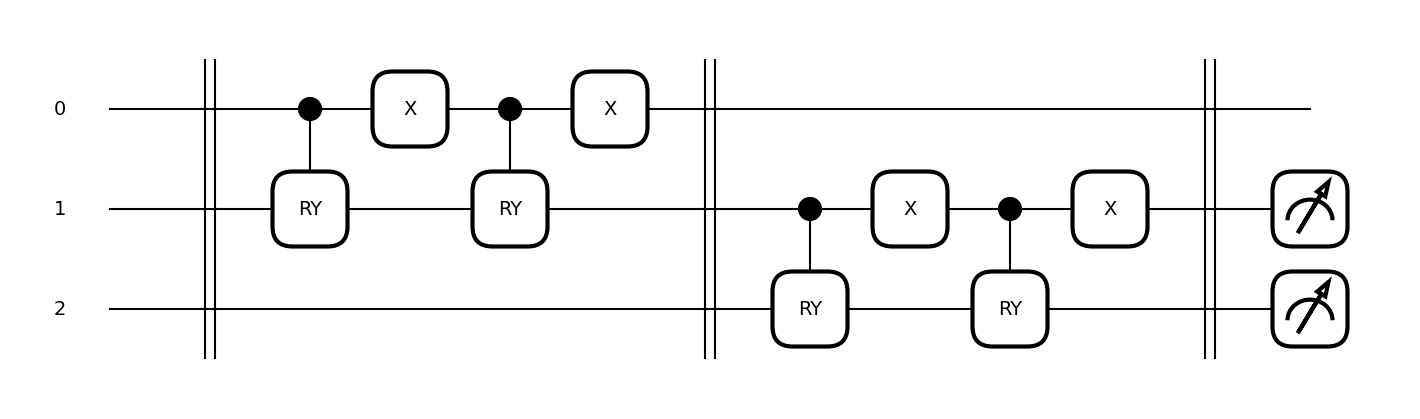

In [178]:
draw_circuit(circuit)

In [179]:
probs = circuit()

idx = ['00', '01', '10', '11']
data = probs
df = pd.DataFrame({"values": data}, columns=["values"], index=idx)
df

,values
00,0.384
01,0.579
10,0.037
11,0.000


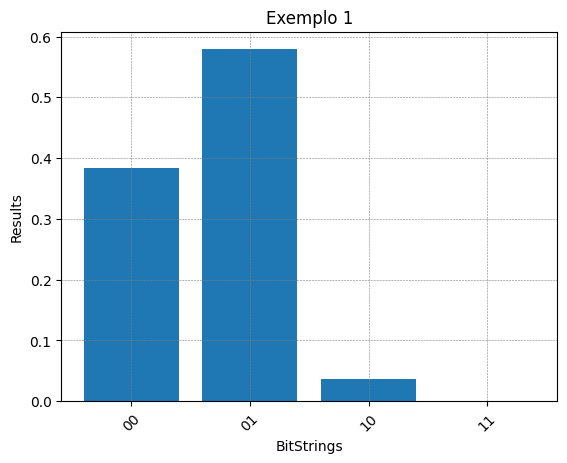

In [180]:
plot(df, "Exemplo 1")

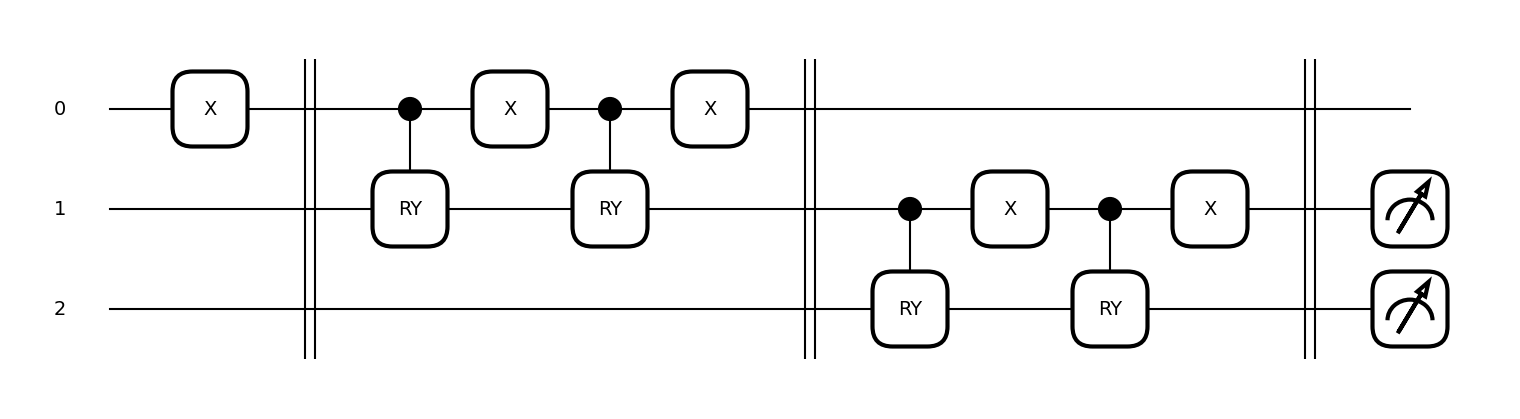

In [181]:
draw_circuit(circuit, True)

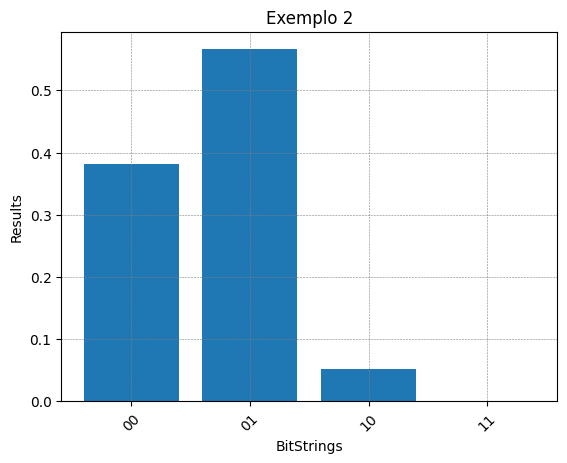

In [182]:
probs = circuit(True)
idx = ['00', '01', '10', '11']
data = probs
df = pd.DataFrame({"values": data}, columns=["values"], index=idx)
plot(df, "Exemplo 2")

---

# Jogo da Velha

In [83]:
N_QUBITS = 9
SHOTS = 1000
qubits_range = list(range(N_QUBITS))

In [84]:
device = qml.device("lightning.qubit", wires=N_QUBITS, shots=SHOTS)
#device_gpu = qml.device("lightning.gpu", wires=N_QUBITS, shots=SHOTS)

In [85]:
class Board:
    def __init__(self):
        self.o = 1
        self.x = 2

        self.o_positions = set()
        self.x_positions = set()
        
        self.board = np.zeros((3,3), dtype=np.int8)

    def play_o(self, pos):
        self._set_pos(pos, self.o)

    def _set_pos(self, pos, player):
        x,y = pos
        assert self.board[x][y] == 0, "Invalid Play!"
        self.board[x][y] = player

        qubit_pos = (x*3)+y
        if(player == self.o):
            self.o_positions.add(qubit_pos)
        else:
            self.x_positions.add(qubit_pos)
            

In [108]:
@qml.qnode(device)
def circuit(board, params):
    for pos in [*list(board.o_positions), *list(board.x_positions)]:
        qml.X(wires=[pos])

    qml.Barrier(wires=qubits_range, only_visual=True)

    param_i = 0
    for i in range(N_QUBITS):
        for j in range(N_QUBITS):
            if(i == j):
                continue
            qml.CRY(params[param_i], wires=[i,j])
            param_i += 1
    
    qml.Barrier(only_visual=True, wires=qubits_range)
    return qml.counts(wires=qubits_range)

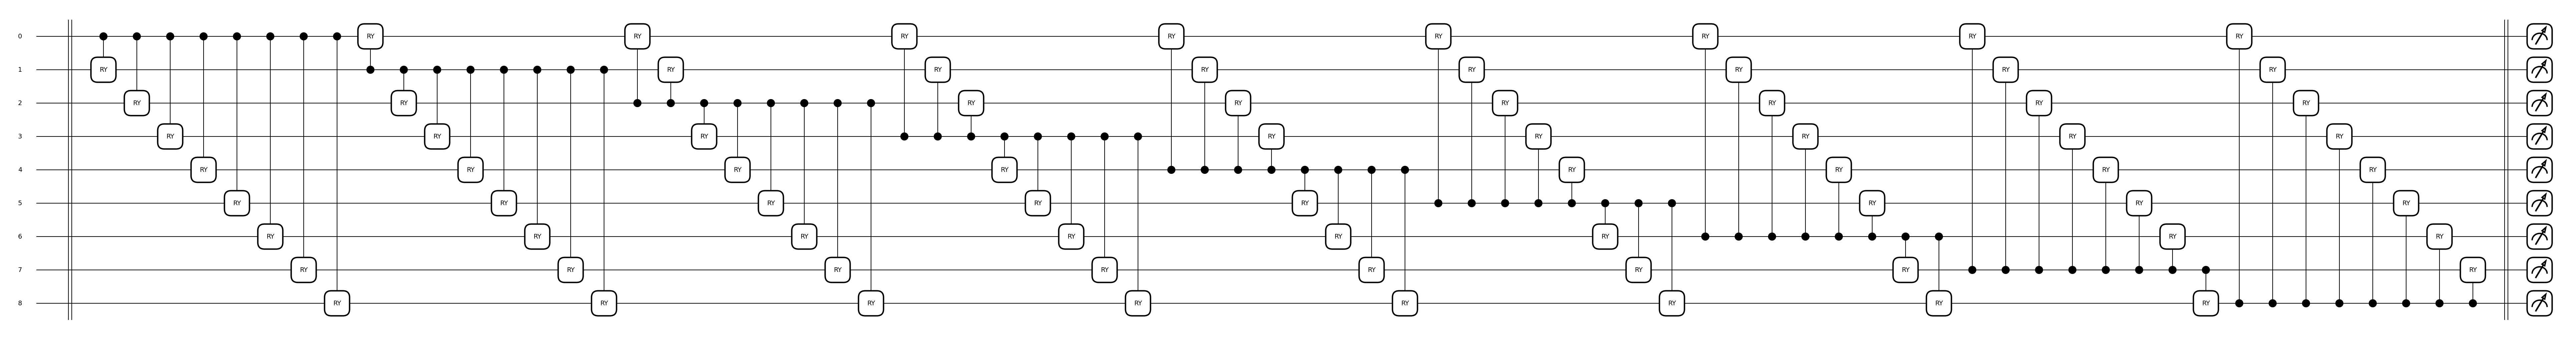

In [107]:
qml.draw_mpl(circuit)(Board(), [0]*81)
plt.show()

In [96]:
board = Board()
while True:
    pos = map(int, input("Your play: ").split())
    board.play_o(pos)
    results = circuit(board)
    print(results)

Your play:  1 1


{'000010000': tensor(1000, requires_grad=True)}


KeyboardInterrupt: Interrupted by user

In [22]:
results = circuit()
sorted_results  = { k:v for k,v in sorted(results.items(), key=lambda item: int(item[0], 2))}

idx = list(sorted_results.keys())
data = list(sorted_results.values())
df = pd.DataFrame({"counts": data}, columns=["counts"], index=idx)
df.head()

,counts
0000,103
0001,65
0010,12
0011,32
0100,99
